# Import Library

In [1]:
import numpy as np
import pandas as pd 
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import model random forest dari file custommodel.py
from custommodel import RandomForestRegressor as RF

# Import Dataset

In [2]:
# membaca file csv
data = pd.read_csv('./data_mangrove_area.csv')

In [3]:
# menampilkan data
data

,year,ndvi,nir,red,area
0,2021-01-01,4127.14,1226.00,0.540770,456.39
1,2022-01-01,4741.40,1508.19,0.516945,497.77
2,2023-01-01,4152.37,1234.85,0.540222,416.00
3,2024-01-01,4187.05,1254.16,0.537683,373.61
4,2025-01-01,4187.05,1254.16,0.537683,332.23


In [4]:
# mengubah format tahun ke datetime
data.year = pd.to_datetime(data.year)

In [5]:
# menampilkan informasi data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    5 non-null      datetime64[ns]
 1   ndvi    5 non-null      float64       
 2   nir     5 non-null      float64       
 3   red     5 non-null      float64       
 4   area    5 non-null      float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 332.0 bytes


# Feature Selection

In [6]:
# memilih atribut dan target
X = data.drop(columns=['area'])
y = data['area']

In [7]:
# menampilkan atribut
X

,year,ndvi,nir,red
0,2021-01-01,4127.14,1226.00,0.540770
1,2022-01-01,4741.40,1508.19,0.516945
2,2023-01-01,4152.37,1234.85,0.540222
3,2024-01-01,4187.05,1254.16,0.537683
4,2025-01-01,4187.05,1254.16,0.537683


In [8]:
# menampilkan target
y

0    456.39
1    497.77
2    416.00
3    373.61
4    332.23
Name: area, dtype: float64

# Hyper Parameter Tuning

In [9]:
# menuliskan skema parameter model
param_grid = {
    "n_estimators": [10, 50, 100, 500, 1000],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}


In [10]:
# membuat semua kombinasi parameter
param_combinations = list(product(*param_grid.values()))

# membuat list untuk menyimpan hasil
results = []

# iterasi setiap kombinasi hyperparameter
for params in param_combinations:
    # unpack parameter
    param_dict = dict(zip(param_grid.keys(), params))
    
    # inisiasi model dan melatih dengan parameter saat ini
    model = RF(**param_dict)
    model.fit(X, y)
    
    # membuat prediksi model
    y_pred = model.predict(X)
    
    # evaluasi prediksi dengan mse
    mse = mean_squared_error(y, y_pred)
    
    # menyimpan hasil pada list result
    results.append({**param_dict, 'MSE': mse})

    # menampilkan hasil
    print(f"Params: {param_dict}, MSE: {mse:.4f}")

# konversi hasil ke dataframe
df_results = pd.DataFrame(results)

Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2}, MSE: 684.9218
Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5}, MSE: 1107.4070
Params: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 10}, MSE: 3494.3204
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 2}, MSE: 684.9218
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 5}, MSE: 1107.4070
Params: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 10}, MSE: 3494.3204
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2}, MSE: 684.9218
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 5}, MSE: 1107.4070
Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10}, MSE: 3494.3204
Params: {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 2}, MSE: 684.9218
Params: {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 5}, MSE: 1107.4070
Params: {'n_estimators': 10, 'max_depth': 20, 'min_s

In [11]:
# menyimpan hasil ke csv
df_results.to_csv('hyperparameter_tuning_results.csv', index=False)

In [12]:
# menampilkan parameter terbaik
best_params = df_results.loc[df_results['MSE'].idxmin()]
print(best_params)

n_estimators         500.00000
max_depth                  NaN
min_samples_split      2.00000
MSE                  684.92176
Name: 36, dtype: float64


In [13]:
# # mengganti none dengan 0 untuk visualisasi
df_results['max_depth'] = df_results['max_depth'].fillna(0)

In [14]:
# mencari parameter terbaik
best_n_estimators = best_params['n_estimators']
best_max_depth = 0 if pd.isna(best_params['max_depth']) else best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

# filter dataframe untuk setiap parameter
df_n_estimators = df_results[(df_results['max_depth'] == best_max_depth) & 
                             (df_results['min_samples_split'] == best_min_samples_split)]

df_max_depth = df_results[(df_results['n_estimators'] == best_n_estimators) & 
                          (df_results['min_samples_split'] == best_min_samples_split)]

df_min_samples_split = df_results[(df_results['n_estimators'] == best_n_estimators) & 
                                  (df_results['max_depth'] == best_max_depth)]

In [15]:
# fungsi untuk plotting
def plot_param_vs_mse(df, param, title, param_values):
    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(x=param, y='MSE', data=df, marker='o')

    for x, y in zip(df[param], df['MSE']):
        plt.text(x, y, f"{y:.2f}", ha='right', va='bottom', fontsize=10, color='black')

    plt.xlabel(param)
    plt.ylabel('MSE')
    plt.title(title)
    plt.xticks(param_values)
    plt.grid()
    plt.show()

In [16]:
# daftar parameter
param_grid = {
    "n_estimators": [10, 50, 100, 500, 1000],
    "max_depth": [0 if v is None else v for v in [None, 5, 10, 20]],
    "min_samples_split": [2, 5, 10],
}

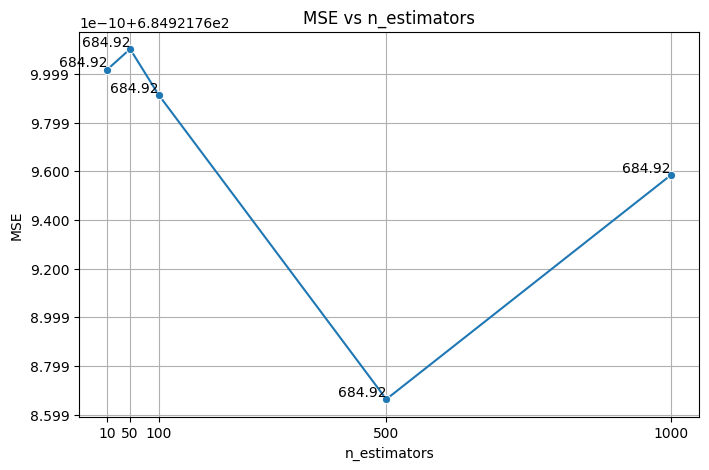

In [17]:
# visualisasi parameter n_estimator
plot_param_vs_mse(df_n_estimators, 'n_estimators', 'MSE vs n_estimators', param_grid['n_estimators'])

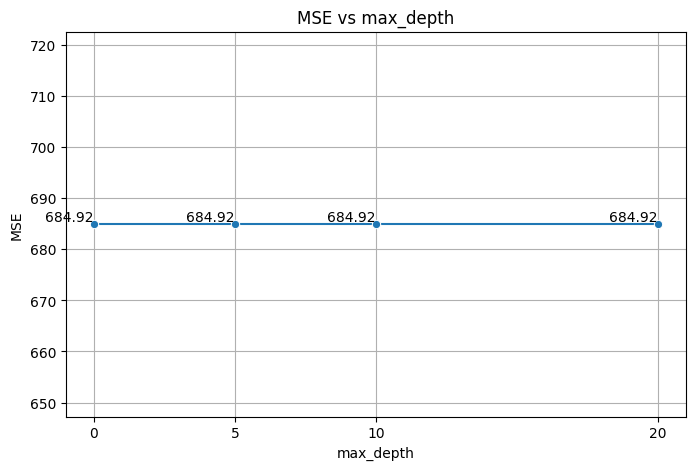

In [18]:
# visualisasi parameter max_depth
plot_param_vs_mse(df_max_depth, 'max_depth', 'MSE vs max_depth', param_grid['max_depth'])

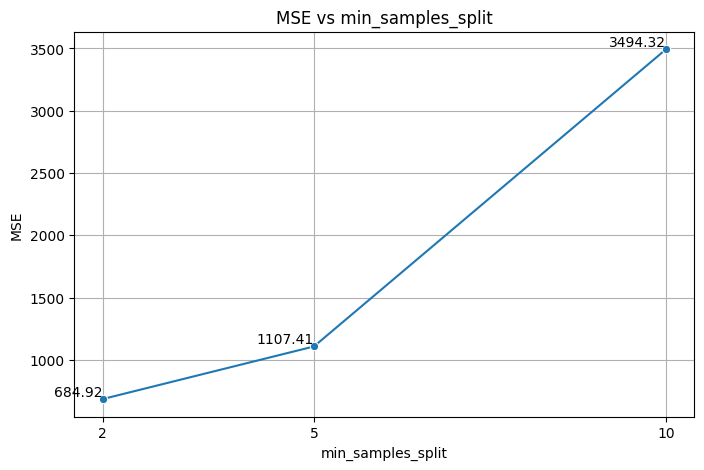

In [19]:
# visualisasi parameter min_sample_split
plot_param_vs_mse(df_min_samples_split, 'min_samples_split', 'MSE vs min_samples_split', param_grid['min_samples_split'])

# Train Random Forest

In [20]:
best_n_estimators = int(best_params['n_estimators']) if not pd.isna(best_params['n_estimators']) else None
best_max_depth = int(best_params['max_depth']) if not pd.isna(best_params['max_depth']) else None
best_min_samples_split = int(best_params['min_samples_split']) if not pd.isna(best_params['min_samples_split']) else None

In [21]:
best_params = best_params.drop('MSE').apply(lambda x: int(x) if not pd.isna(x) else x).to_dict()

In [22]:
# melatih model berdasarkan parameter terbaik
rf = RF(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, verbose=True)
rf.fit(X, y)

Tree 1/500 telah dilatih.
Tree 2/500 telah dilatih.
Tree 3/500 telah dilatih.
Tree 4/500 telah dilatih.
Tree 5/500 telah dilatih.
Tree 6/500 telah dilatih.
Tree 7/500 telah dilatih.
Tree 8/500 telah dilatih.
Tree 9/500 telah dilatih.
Tree 10/500 telah dilatih.
Tree 11/500 telah dilatih.
Tree 12/500 telah dilatih.
Tree 13/500 telah dilatih.
Tree 14/500 telah dilatih.
Tree 15/500 telah dilatih.
Tree 16/500 telah dilatih.
Tree 17/500 telah dilatih.
Tree 18/500 telah dilatih.
Tree 19/500 telah dilatih.
Tree 20/500 telah dilatih.
Tree 21/500 telah dilatih.
Tree 22/500 telah dilatih.
Tree 23/500 telah dilatih.
Tree 24/500 telah dilatih.
Tree 25/500 telah dilatih.
Tree 26/500 telah dilatih.
Tree 27/500 telah dilatih.
Tree 28/500 telah dilatih.
Tree 29/500 telah dilatih.
Tree 30/500 telah dilatih.
Tree 31/500 telah dilatih.
Tree 32/500 telah dilatih.
Tree 33/500 telah dilatih.
Tree 34/500 telah dilatih.
Tree 35/500 telah dilatih.
Tree 36/500 telah dilatih.
Tree 37/500 telah dilatih.
Tree 38/50

# Evaluate the Model

In [23]:
# evaluasi dengan mse
mse = mean_squared_error(y, rf.predict(X))

In [24]:
# evaluasi dengan mae
mae = mean_absolute_error(y, rf.predict(X))

In [25]:
df_result = pd.DataFrame({
    "Metric": ["MSE", "MAE"],
    "Value": [mse, mae]
})

print(df_result)

  Metric      Value
0    MSE  684.92176
1    MAE   16.55200


# Save the Model

In [26]:
# menyimpan model ke file pickle
rf.save_model("./rfmodel.pkl")